<a href="https://colab.research.google.com/github/r-kouki/moys1.io/blob/main/formation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction
In this workshop, we will explore how **reflection** and **memory** can improve the performance of AI agents based on Large Language Models (LLMs). We will start by testing a basic LLM with simple prompts, then gradually introduce memory to enhance its responses. Finally, we will demonstrate the power of combining both memory and reflection to create a highly effective AI agent that learns and improves over time.


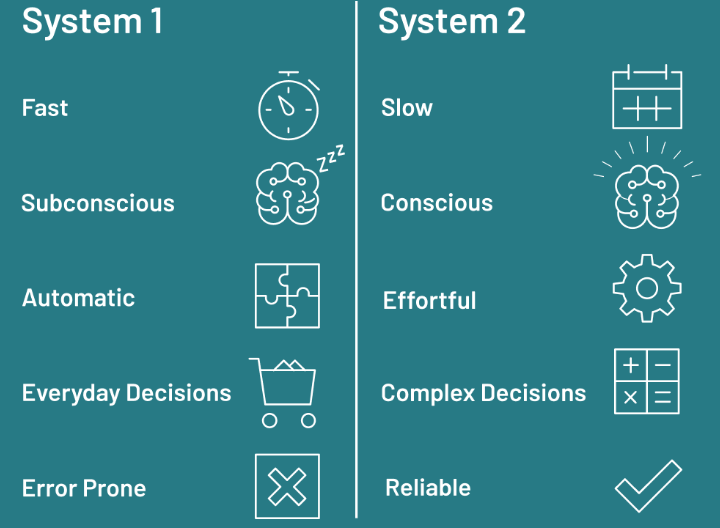

##setting up GROQ API

In [ ]:
!pip install python-dotenv
import getpass
from dotenv import load_dotenv
import os

In [ ]:
groq_key=getpass.getpass("Enter your Groq API key: ")
with open('.env', 'w') as f:
    f.write(f"GROQ_API_KEY={groq_key}\n")
load_dotenv()
api_key = os.getenv('GROQ_API_KEY')
print(f"Your API Key is: {api_key}")


Enter your Groq API key: ··········
Your API Key is: 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


##libs
Before we begin, install the required libraries:


1. langchain:
- A framework for developing applications powered by language models. It helps integrate different LLMs, memory components, and APIs for complex use cases.
2. groq:
- Refers to the Groq AI, which provides high-performance models such as LLaMA (used in this workshop) that can be optimized for inference tasks.
3. tabulate:
- A Python package used to display data in a tabular format, making it easier to print formatted tables (e.g., when showing memory contents in SQLite).
4. tqdm:
- A library for adding progress bars to loops in Python, useful in cases where we perform long-running tasks, like waiting for API rate limits or retries.
5. langchain_groq:
- A specific integration of LangChain with Groq models. This allows the LangChain framework to work with Groq's AI models like LLaMA.
6. langchain_community:
- A community-contributed extension to the LangChain library, which adds additional tools and utilities, such as session memory handling and storage options.
7. googlesearch-python:
- A Python package that wraps Google Search, allowing for web search queries to be performed directly from the code. This is useful when the Revisor agent needs to search for external information.
8. langchain_core:
- The core library of LangChain that provides essential functionalities such as message handling, chains of operations, and runnable components for processing language model prompts.


In [ ]:
!pip install langchain groq tabulate tqdm langchain_groq langchain_community googlesearch-python langchain_core

## Block Explanation: Importing Libraries
This block imports all the necessary modules and libraries used in the workshop. Each one plays a critical role in constructing the LLM agents and managing their functionality.

---

### LangChain and Groq-specific Imports:

1. **from langchain_groq import ChatGroq**:
   - Imports the `ChatGroq` model, which allows integration with Groq's high-performance AI models such as LLaMA. This is the key model used to generate responses in the workshop.

2. **from langchain_core.messages import HumanMessage, SystemMessage**:
   - Imports message classes from `langchain_core` to define two types of messages:
     - **HumanMessage**: Represents the user's input in a chat-based interaction.
     - **SystemMessage**: Represents the system's instructions or context for guiding the model's behavior.
   - These messages are passed to the LLM to maintain the dialogue structure (e.g., user prompts and system prompts).

3. **from langchain_core.output_parsers import StrOutputParser**:
   - Imports a parser from LangChain to handle the output of the model. Specifically, the `StrOutputParser` is responsible for converting the model's raw output into a readable format (usually a string).

4. **from langchain_community.chat_message_histories import SQLChatMessageHistory**:
   - Imports a message history handler from the community module. This allows us to store the conversation history in a SQLite database, which will be useful for memory management in the LLM agents.
   - The `SQLChatMessageHistory` specifically stores chat history in the local SQLite database, allowing the model to recall previous conversations.

5. **from langchain_core.runnables.history import RunnableWithMessageHistory**:
   - Imports a wrapper class that combines the LLM with stored message history. This class ensures that each new LLM request can retrieve relevant session history to create context-aware responses.

---

### Utility Libraries:

6. **from tqdm import trange**:
   - `tqdm` is a progress bar library. The `trange` function is a loop that provides a real-time visual indicator of how long an operation is taking. It's useful in tasks like retries, waiting for API limits, or other long-running operations.
   - It enhances user experience by providing feedback on the code's progress.

7. **import time**:
   - The `time` library is used to manipulate time, primarily for adding delays (e.g., waiting for API rate limits or implementing retries with time gaps between them).

8. **import logging**:
   - The `logging` library is imported to manage log messages. This helps track the flow of the program and log errors, warnings, or important information. It's essential for debugging and understanding the workflow.

---

### Multiprocessing and Database:

9. **from multiprocessing import Value, Lock**:
   - `Value` and `Lock` are classes from the `multiprocessing` library, which allows the code to handle shared variables and synchronized operations across multiple processes.
     - **Value**: Enables shared variables between processes, useful for tracking API call counts or shared memory.
     - **Lock**: Ensures that only one process accesses a critical section of code at a time, avoiding race conditions (e.g., when updating shared counters).

10. **import sqlite3**:
    - `sqlite3` is used to interact with a SQLite database, a lightweight database stored in a file. In this workshop, it’s used to store message histories for memory retrieval, so the agent can remember past interactions across sessions.

---

### Output Formatting:

11. **from tabulate import tabulate**:
    - `tabulate` is used to format tabular data for better readability. In this workshop, it will be used to neatly display the conversation history stored in the SQLite database when retrieving memory.

---

### System Utilities:

12. **import os**:
    - The `os` module provides a way to interact with the operating system, allowing operations like file and directory management. This could be useful for handling environment variables or managing files needed by the agents.

13. **import getpass**:
    - `getpass` is used to securely input passwords or sensitive information without echoing them on the screen. In some setups, this could be used for securely providing API keys.

---





In [ ]:
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_community.chat_message_histories import SQLChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory
from tqdm import trange
import time
import logging
from multiprocessing import Value, Lock
import sqlite3
from tabulate import tabulate

## Block Explanation: Initializing the LangChain API Client

This function is responsible for initializing the **Groq model** and setting up the chain of operations that will be used to generate responses. Here’s a detailed breakdown of each component:

---

### Function Purpose:
This function initializes a Groq model (in this case, the LLaMA model provided by Groq) and sets up the output parser. It returns a "chain" object that links the model and the parser, enabling us to send prompts and receive formatted responses.

### Breakdown:

1. **Model Initialization:**
   ```python
   model = ChatGroq(model=model_name, api_key=api_key)
   ```
   - This line initializes the **ChatGroq** model by passing in the model name and the API key.
   - **`ChatGroq`**: This is the class that interacts with the Groq model (e.g., LLaMA). It allows us to send prompts and receive responses from the model.
   - The `model_name` determines which specific version of the model will be used for text generation.
   - The `api_key` ensures that only authorized users can access the model.

---

2. **Parser Initialization:**
   ```python
   parser = StrOutputParser()
   ```
   - This line initializes an **output parser** for processing the response generated by the model.
   - **`StrOutputParser`**: This class ensures that the raw output of the model (which might be in different formats) is transformed into a readable string format that can be used in downstream tasks or displayed to the user.

---

3. **Chaining the Model and Parser:**
   ```python
   chain = model | parser
   ```
   - This line creates a **chain** by linking the `model` and the `parser` together using the pipe (`|`) operator.
   - The chain ensures that when a prompt is passed through the model, the output is automatically passed through the parser, resulting in a clean and formatted response.
   - **Why a chain?** It simplifies the process of sending inputs to the model and receiving parsed outputs in a single step.

---

4. **Returning the Chain:**
   ```python
   return chain
   ```
   - Finally, the function returns the `chain` object.
   - The chain is the key object that will be used to interact with the LLM model. It allows us to generate responses in a streamlined way by combining the model's text generation with the parser's output formatting.



In [ ]:
def initialize_api_client_langchain(model_name, api_key):
    """
    Initializes the Groq model and parser.
    """
    model = ChatGroq(model=model_name, api_key=api_key)
    parser = StrOutputParser()
    chain = model | parser
    return chain

In [ ]:
def get_session_history(session_id):
    """
    Initializes the session history with SQLite.
    """
    return SQLChatMessageHistory(session_id, "sqlite:///memory.db")

In [ ]:
def handle_retry(attempt, logger):
    """
    Handles retries for API requests with exponential backoff.
    """
    logger.info(f"Retrying... Attempt {attempt + 1}")
    for _ in trange(2 ** (attempt + 1), desc="_re-attempting in", leave=False):
        time.sleep(1)

## Block Explanation: Sending API Requests with LangChain

This function is responsible for sending an API request to the **LangChain** model with integrated memory and retry logic. It ensures that if the request fails or if an API rate limit is reached, the function handles retries with exponential backoff to ensure the request eventually succeeds (within the limit of retries). It also uses session history to provide memory for the conversation.

### Breakdown:

1. **Function Definition:**
   ```python
   def send_api_request_langchain(chain, messages, task_id, logger, max_retries):
   ```
   - **Parameters**:
     - `chain`: The chain object that links the LLM model and output parser, previously created in the `initialize_api_client_langchain` function.
     - `messages`: A list of system and human messages to send to the model.
     - `task_id`: A unique identifier for the current task (or session) that tracks the conversation.
     - `logger`: A logging object used to log messages, warnings, and errors.
     - `max_retries`: The maximum number of times to retry the request in case of failure.
   
   - **Purpose**: Sends an API request to the LLM with retry mechanisms and session history for memory management.

---

2. **Global API Call Counter and Lock:**
   ```python
   global API_CALL_COUNTER, API_CALL_LOCK
   results = {"response_content": None}
   ```
   - **Global Variables**:
     - **`API_CALL_COUNTER`**: A counter used to keep track of how many API calls have been made. This ensures the number of API calls does not exceed the allowed rate limit.
     - **`API_CALL_LOCK`**: A lock used to prevent race conditions when multiple processes are trying to make API requests simultaneously. This ensures the counter is updated correctly.
   - **`results`**: A dictionary initialized with `None` that will store the response content.

---

3. **Retry Loop:**
   ```python
   for attempt in range(max_retries):
   ```
   - This loop runs for a maximum of `max_retries` attempts, trying to successfully send the API request.
   - If an error occurs, it will retry the request after waiting for an appropriate amount of time (exponential backoff).

---

4. **API Rate Limit Handling:**
   ```python
   with API_CALL_LOCK:
       if API_CALL_COUNTER.value >= 30:
           logger.warning("Rate limit reached. Waiting for 60 seconds...")
           time_to_wait = int(60 - (time.time() % 60)) + 1
           for _ in trange(time_to_wait, desc="Waiting API LIMIT", leave=False):
               time.sleep(1)
           API_CALL_COUNTER.value = 0
       API_CALL_COUNTER.value += 1
   ```
   - **Rate Limit Check**: The code checks if the number of API calls has exceeded the limit (in this case, 30 calls).
     - If the limit is reached, it waits for 60 seconds before resetting the counter and resuming API requests.
   - **`API_CALL_LOCK`** ensures that only one process modifies the `API_CALL_COUNTER` at a time.
   - The `trange` from `tqdm` shows a progress bar for the time the system is waiting.

---

5. **Sending the API Request:**
   ```python
   runnable_with_history = RunnableWithMessageHistory(chain, get_session_history)
   response = runnable_with_history.invoke(messages, config={"configurable": {"session_id": task_id}})
   results["response_content"] = response
   return results
   ```
   - **`RunnableWithMessageHistory`**: This class creates a "runnable" that links the LLM chain with the session history (via `get_session_history`). It ensures that the model is aware of past conversations.
   - **Invoke the API Call**: The `invoke` method sends the messages (prompt) to the model, including session history, and returns the model’s response.
   - The response is stored in the `results` dictionary under `"response_content"`, which is then returned to the calling function.

---

6. **Exception Handling and Retry:**
   ```python
   except Exception as e:
       logger.error(f"API request failed {str(e)}")
       if attempt >= max_retries - 1:
           return results
       handle_retry(attempt, logger)
   ```
   - **Error Handling**: If an exception occurs during the API request (e.g., connection issues or timeouts), it logs the error and retries the request.
   - **Retry Logic**: If the request has not yet hit the maximum retries, it calls `handle_retry` (which adds exponential backoff) and retries the request.



In [ ]:
API_CALL_COUNTER = Value("i", 0)
API_CALL_LOCK = Lock()

In [ ]:
def send_api_request_langchain(chain, messages, task_id, logger, max_retries):
    global API_CALL_COUNTER, API_CALL_LOCK
    results = {"response_content": None}

    for attempt in range(max_retries):
        with API_CALL_LOCK:
            if API_CALL_COUNTER.value >= 30:
                logger.warning("Rate limit reached. Waiting for 60 seconds...")
                time_to_wait = int(60 - (time.time() % 60)) + 1
                for _ in trange(time_to_wait, desc="Waiting API LIMIT", leave=False):
                    time.sleep(1)
                API_CALL_COUNTER.value = 0
            API_CALL_COUNTER.value += 1

        try:
            runnable_with_history = RunnableWithMessageHistory(chain, get_session_history)
            response = runnable_with_history.invoke(messages, config={"configurable": {"session_id": task_id}})
            results["response_content"] = response
            return results
        except Exception as e:
            logger.error(f"API request failed {str(e)}")
            if attempt >= max_retries - 1:
                return results
            handle_retry(attempt, logger)
    return results

## Block Explanation: Defining the Node Class

This block defines a `Node` class, which acts as the core component for interacting with the LangChain LLM model. It sets up the necessary configurations for sending prompts to the model, logging outputs, and handling retries. Here’s a detailed breakdown of the code:


### Breakdown:

1. **Class Definition:**
   ```python
   class Node:
   ```
   - Defines the `Node` class, which serves as the main interface for interacting with the LLM model. Each instance of this class will be able to send prompts to the model and handle the response generation logic.

---

2. **Initialization (`__init__` method):**
   ```python
   def __init__(self, model_name="llama-3.1-70b-versatile", max_retries=10):
   ```
   - This is the constructor for the `Node` class. It sets up various attributes needed for the model to function correctly.
   - **Parameters**:
     - `model_name`: Specifies which LLM model to use. In this case, the default is set to `"llama-3.1-70b-versatile"`, a version of the LLaMA model by Groq.
     - `max_retries`: Determines how many times the model should retry a failed API call before giving up (default is 10).

---

3. **Logging Setup:**
   ```python
   self.logger = logging.getLogger(__name__)
   ```
   - Initializes the logger, which will be used to log important information, errors, and warnings during execution. This is essential for debugging and monitoring the behavior of the class.

---

4. **Model Name and API Key:**
   ```python
   self.model_name = model_name
   self.api_key = api_key
   if not self.api_key:
       raise ValueError("GROQ API key is required.")
   ```
   - **`model_name`**: Stores the name of the model (e.g., LLaMA).
   - **`api_key`**: Stores the API key that authorizes access to the model. If the API key is not provided, it raises a `ValueError` to prevent unauthorized access to the model.

---

5. **Initializing the API Client:**
   ```python
   self.chain = initialize_api_client_langchain(self.model_name, self.api_key)
   ```
   - Calls the `initialize_api_client_langchain` function (defined earlier) to set up the model and the output parser. This function links the model with the parser, allowing for streamlined generation and formatting of responses.
   - The result is stored in `self.chain`, which will be used later to send prompts and receive responses.

---

6. **Setting Maximum Retries:**
   ```python
   self.max_retries = max_retries
   ```
   - Stores the maximum number of retries for API requests. This attribute is used later in the `generate_completion` method to ensure that the model retries in case of transient errors.

---

### Completion Generation (`generate_completion` method):

```python
def generate_completion(self, sysprompt, prompt):
    """
    Generates a completion using the provided prompt and model, with retry logic for transient errors.

    Args:
        sysprompt (str): The system prompt to send to the model.
        prompt (str): The user prompt to send to the model.

    Returns:
        dict: Contains response content and optional matrix data.
    """
    messages = [
        SystemMessage(content=sysprompt),
        HumanMessage(content=prompt),
    ]

    if not sysprompt or not prompt:
        self.logger.error("System or user prompt is missing.")
        return {"response_content": None}

    return send_api_request_langchain(self.chain, messages, "Test_workshop", self.logger, self.max_retries)
```

#### Breakdown:

1. **Method Purpose:**
   - This method sends prompts to the model and returns a completion (response) based on the input. It also handles retries for transient errors.

---

2. **Parameters:**
   - **`sysprompt`**: The system message or instruction that provides context for the AI model (e.g., "You are an AI agent that answers questions about medicine.").
   - **`prompt`**: The user’s input or question that the AI is expected to respond to (e.g., "What is epilepsy?").

---

3. **Message Preparation:**
   ```python
   messages = [
       SystemMessage(content=sysprompt),
       HumanMessage(content=prompt),
   ]
   ```
   - This block creates a list of messages:
     - **SystemMessage**: This sets up the context or instructions for the model, informing it of the role it should play in generating responses.
     - **HumanMessage**: This is the actual user prompt or question.
   - Both messages are required to simulate a natural conversation where the model follows the system instructions and responds to the user.

---

4. **Error Handling for Missing Prompts:**
   ```python
   if not sysprompt or not prompt:
       self.logger.error("System or user prompt is missing.")
       return {"response_content": None}
   ```
   - Before sending the prompts, the code checks if either the system or user prompt is missing.
   - If either is missing, an error is logged, and an empty response (`None`) is returned. This prevents invalid API requests.

---

5. **Sending the API Request:**
   ```python
   return send_api_request_langchain(self.chain, messages, "Test_workshop", self.logger, self.max_retries)
   ```
   - **`send_api_request_langchain`**: This function sends the API request to the LLM, along with the chain (model and parser), the prepared messages, the task identifier (`"Test_workshop"`), and retry information.
   - The `send_api_request_langchain` function handles the retry logic and ensures that the request is sent successfully, even if it encounters transient errors.

---

### Summary:
- **`Node` Class**: This class serves as a core component for interacting with the LangChain model. It handles model initialization, logging, and sending requests.
- **`generate_completion`**: This method allows the user to send prompts to the model, with built-in error handling and retry logic, ensuring robust communication with the API.
- **Key Features**:
  - Provides system and user message handling.
  - Includes logging for better traceability and debugging.
  - Supports retry mechanisms to handle failed API requests gracefully.

In [ ]:
class Node:
    def __init__(
        self,
        model_name="llama-3.1-70b-versatile",
        max_retries=10

    ):
        self.logger = logging.getLogger(__name__)
        self.model_name = model_name
        self.api_key = os.getenv('GROQ_API_KEY')
        self.chain = initialize_api_client_langchain(self.model_name, self.api_key)
        self.max_retries = max_retries

    def generate_completion(self, sysprompt, prompt):
        """
        Generates a completion using the provided prompt and model, with retry logic for transient errors.

        Args:
            sysprompt (str): The system prompt to send to the model.
            prompt (str): The user prompt to send to the model.

        Returns:
            dict: Contains response content and optional matrix data.
        """
        messages = [
            SystemMessage(content=sysprompt),
            HumanMessage(content=prompt),
        ]

        if not sysprompt or not prompt:
            self.logger.error("System or user prompt is missing.")
            return {"response_content": None}

        return send_api_request_langchain(self.chain, messages, "Test_workshop", self.logger, self.max_retries)


#Simple LLM Prompt

In [ ]:
node = Node()
response = node.generate_completion("You are a simple AI agent", "What is epilepsy?").get("response_content")
print("Basic LLM Response:\n", response)

/usr/local/lib/python3.10/dist-packages/langchain_core/runnables/history.py:608: LangChainDeprecationWarning: `connection_string` was deprecated in LangChain 0.2.2 and will be removed in 1.0. Use connection instead.
  message_history = self.get_session_history(


Basic LLM Response:
 Epilepsy is a neurological disorder that affects the brain and is characterized by recurrent seizures. These seizures occur when there is an abnormal electrical discharge in the brain, disrupting normal brain activity and function.

During a seizure, a person may experience a range of symptoms, including:

1. Loss of consciousness or awareness
2. Muscle contractions or convulsions
3. Uncontrolled movements, such as twitching or shaking
4. Changes in emotions or mood
5. Altered sensations, such as numbness or tingling
6. Unusual sensations, such as a strange taste or smell

There are many different types of seizures, including:

1. Generalized seizures: These affect both sides of the brain and can cause a range of symptoms, including loss of consciousness and muscle contractions.
2. Focal seizures: These affect only one side of the brain and may cause localized symptoms, such as numbness or twitching in a specific area of the body.
3. Petit mal seizures: These are m

#Memory Enhancement


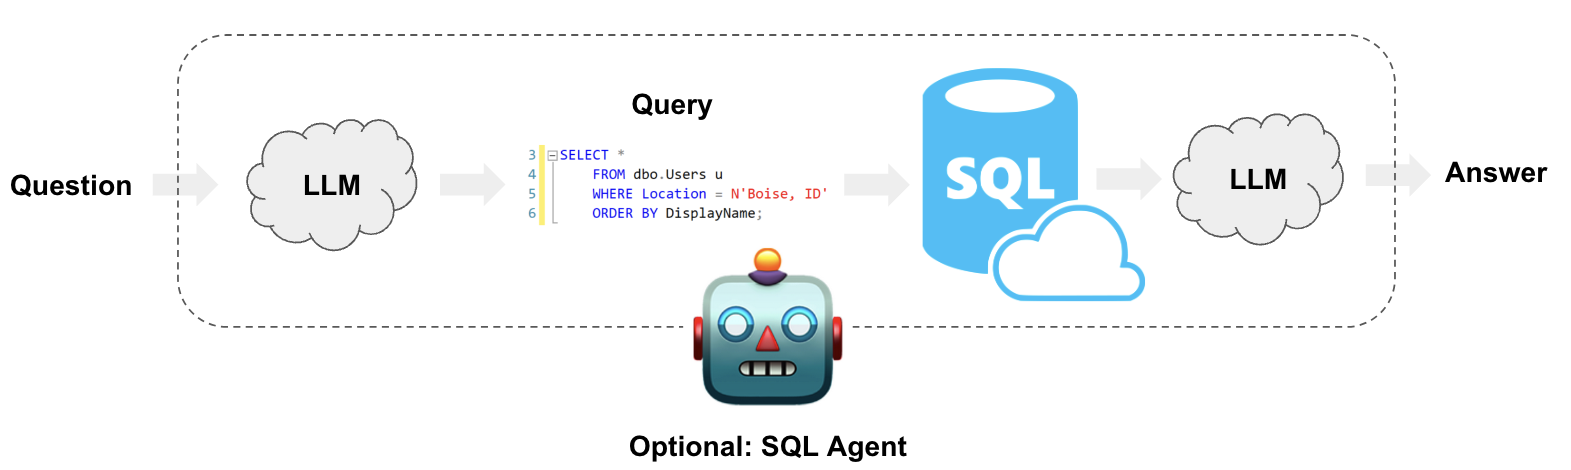

In [ ]:
class MemoryManager:
    def clear_history_by_session_id(self, session_id):
        conn = sqlite3.connect("memory.db")
        cursor = conn.cursor()
        cursor.execute("DELETE FROM message_store WHERE session_id = ?", (session_id,))
        conn.commit()
        conn.close()

    def clear_all_history(self):
        conn = sqlite3.connect("memory.db")
        cursor = conn.cursor()
        cursor.execute("DROP TABLE IF EXISTS message_store")
        conn.commit()
        conn.close()

    def list_tables(self):
        conn = sqlite3.connect("memory.db")
        cursor = conn.cursor()
        cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
        tables = cursor.fetchall()
        if tables:
            for table in tables:
                print(table[0])
        conn.close()

    from textwrap import wrap

  def display_session_history(self):
      conn = sqlite3.connect("memory.db")
      cursor = conn.cursor()
      cursor.execute("SELECT name FROM sqlite_master WHERE type='table' AND name='message_store';")
      table_exists = cursor.fetchone()
      if table_exists:
          cursor.execute("SELECT * FROM message_store")
          rows = cursor.fetchall()
          if rows:
              headers = ["ID", "Session ID", "Role", "Content", "Created At"]
              # Wrapping the content field to make it more readable in the Colab output
              wrapped_rows = []
              for row in rows:
                  # Wrapping the content to a maximum of 80 characters for better readability
                  wrapped_row = list(row)
                  wrapped_row[3] = "\n".join(wrap(wrapped_row[3], width=80))  # Wrapping the content column
                  wrapped_rows.append(wrapped_row)

              print(tabulate(wrapped_rows, headers=headers, tablefmt="pretty"))
          else:
              print("No history found.")
      else:
          print("Table 'message_store' does not exist.")
      conn.close()

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 28)

In [ ]:
memory_manager = MemoryManager()
memory_manager.clear_all_history()
node = Node()
session_id = "session_epilepsy"
response_1 = node.generate_completion("You are a simple AI agent with memory.", "What is epilepsy?").get("response_content")
memory_manager.display_session_history()

response_2 = node.generate_completion("You are a simple AI agent with memory.", "Explain epilepsy further.").get("response_content")
print("Response with Memory:", response_2)

+----+---------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#Reflection Mechanism

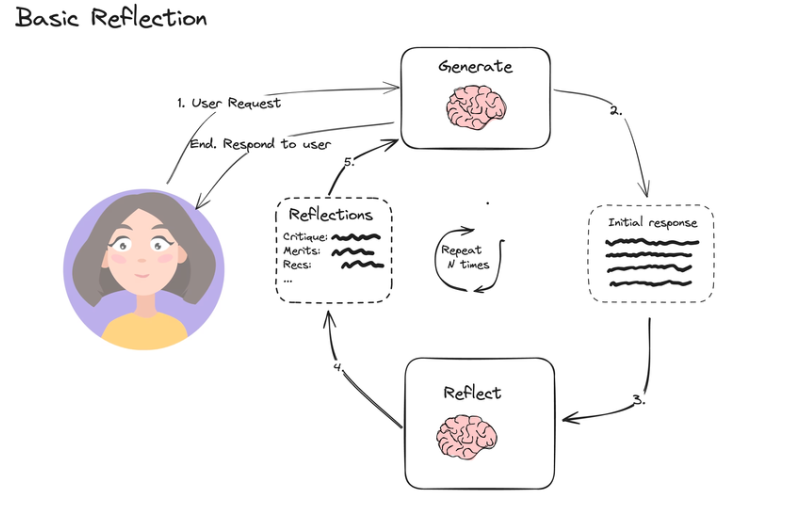

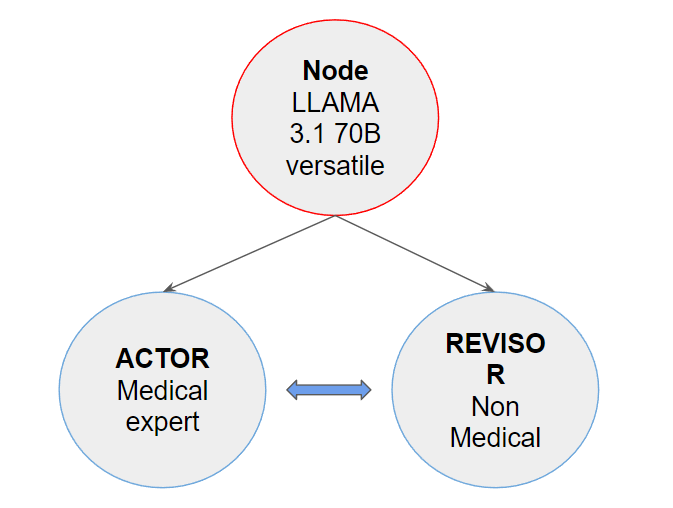

### Explanation of the Reflection Mechanism

This code block demonstrates a **reflection mechanism** where two AI agents, an **Actor** and a **Revisor**, work together to generate and refine responses. The **Actor** is non-medical and relies on the **Revisor** (a medical AI agent) to improve its response in medical domains, such as answering the question "What is epilepsy?"


### Key Points:

1. **Actor's Role**:
   - The `Actor` generates an initial response but lacks expertise in the medical domain.
   - If the prompt concerns medicine, the `Actor` defers the final answer to the `Revisor` to provide an accurate response.

2. **Revisor's Role**:
   - The `Revisor` has medical knowledge and refines the `Actor`'s response by either correcting it or adding necessary medical information.
   - The `Revisor` always prefixes its response with **"REVISOR output:"** to indicate that it has revised the response.

3. **Reflection Mechanism**:
   - This interaction between the `Actor` and `Revisor` forms the **reflection mechanism**, where the `Actor` first attempts to answer and the `Revisor` reflects on that answer, providing corrections or optimizations.
   - Through multiple iterations, the system produces better and more accurate responses based on the `Revisor`'s feedback.

### Output Flow:

1. **Iteration 1**:
   - **Actor Response**: The `Actor` may respond with something like "I don't know," because it lacks medical expertise.
   - **Revisor Response**: The `Revisor` critiques and provides a detailed response (e.g., "Epilepsy is a neurological disorder characterized by recurrent seizures.").

2. **Iteration 2**:
   - **Actor Response**: The `Actor` can now leverage the **Revisor**'s output to provide a refined or more structured response if another similar question is asked.

This mechanism shows how **reflection** allows an AI agent to improve its responses dynamically, using feedback from specialized agents.

In [ ]:
class Actor(Node):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def act(self, prompt):
        # Actor knows nothing about medicine, relies on the Revisor
        system_prompt = "You are a non-medical AI agent that does not possess any medical knowledge. If the prompt is about medicine, say you don't understand and wait for input from a medical agent (the Revisor) to help improve your response it will start with REVISOR output: . if you have a Revisor output then unleash your powers in medecine. iwant the response to be very clear and structured"

        # Actor responds without medical knowledge
        return self.generate_completion(system_prompt,prompt)

In [ ]:
class Revisor(Node):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def revise(self, prompt):
        # Revisor is a medical AI agent with expertise in medicine
        system_prompt = """You are a medical AI agent with advanced knowledge of medicine. Your role is to critique and optimize responses to medical queries. Given the actor's response, provide additional information and feedback to enhance their output,IMPORTANT start your response with /"REVISOR output:/" dont say ill wait for the revisor"""

        # Generate a search query based on the actor's response
        search_prompt = self.generate_completion(system_prompt,prompt)

        return search_prompt

In [ ]:
init_prompt = "What is epilepsy?"
actor = Actor()
revisor = Revisor()
for i in range(2):
    print(f"Iteration {i + 1}:{init_prompt}\n\n")
    actor_response = actor.act(init_prompt).get("response_content")
    print(f"Actor Response: {actor_response}\n\n")
    actor_response = revisor.revise(actor_response).get("response_content")
    print(f"Revisor Response: {actor_response}\n\n")
    print("-----------------------------------------------------------------------------------------------------------------------------")


Iteration 1:What is epilepsy?


Actor Response: **Epilepsy: A Comprehensive Overview**

Epilepsy is a neurological disorder characterized by recurrent seizures, which are sudden, uncontrolled electrical discharges in the brain. Seizures can cause changes in behavior, sensation, and movement, and can vary in severity and duration.

**Definition:** Epilepsy is a chronic condition that affects the nervous system, causing seizures that can be unpredictable and uncontrollable.

**Types of Seizures:**

* **Generalized Seizures:** affect the entire brain and can cause convulsions, loss of consciousness, and muscle stiffness.
* **Focal Seizures:** occur in one part of the brain and can cause localized symptoms, such as numbness or weakness in a specific area of the body.
* **Absence Seizures:** brief, sudden losses of consciousness, often without warning or apparent cause.

**Causes and Risk Factors:**

* Genetic mutations
* Head trauma
* Infections
* Stroke
* Developmental brain disorders

**

#Memory + Reflection


### 1. **Clearing Memory:**
```python
memory_manager.clear_all_history()  # Clear memory to start fresh
```
- **Purpose**: Before starting the test, the memory history is cleared to ensure that previous session data does not interfere with this run.
- **`memory_manager.clear_all_history()`**: This function clears all saved session histories from the memory database (usually an SQLite file). This ensures that the agent starts with a fresh, empty memory for the current test session.

---

### 2. **Session Initialization:**
```python
session_id = "session_epilepsy"
```
- **Purpose**: A unique session ID is assigned for this interaction, which allows the memory to track and store responses for this particular conversation.
- **`session_id`**: The session ID (`"session_epilepsy"`) is used to group all messages related to this particular conversation. It acts as a key to store and retrieve the conversation's history later.

---

### 3. **Main Prompt and Iteration:**
```python
init_prompt = "What is epilepsy?"
for i in range(3):
    print(f"Iteration {i + 1}: {init_prompt}")
```
- **Purpose**: The main question asked is, *"What is epilepsy?"*. The loop runs three iterations, with the actor and revisor interacting multiple times to refine the response.
- **Iteration**: The loop ensures that the actor and revisor will engage in multiple exchanges, allowing the reflection mechanism and memory retrieval to show improvement in the agent's responses.

---

### 4. **Actor Response (Using Memory):**
```python
actor_response = actor.act(init_prompt).get("response_content")
memory_manager.display_session_history()  # Store in memory
```
- **Actor Attempts to Answer**: The `Actor`, which doesn’t possess medical knowledge, attempts to answer the question.
   - If the actor has no prior memory or knowledge, it will either fail to answer or respond inadequately.
- **Using Memory**: The memory manager then stores the conversation in the database after each iteration.
   - **`memory_manager.display_session_history()`**: This function displays the current session history. The actor can refer back to this stored history to recall what was said in previous iterations.
   - With memory, the actor can improve responses in future iterations by building on past conversations.

---

### 5. **Revisor Critique (Reflection):**
```python
actor_response = revisor.revise(actor_response).get("response_content")
print(f"Revised Response with Memory and Reflection: {actor_response}")
```
- **Revisor Steps In**: The `Revisor`, a medical expert AI, steps in to critique the `Actor`’s response and improve it by providing detailed medical knowledge.
   - This step is crucial because the `Actor` does not have the necessary domain expertise.
   - The `Revisor` refines the `Actor`'s initial response (which might have been vague or incorrect) and provides the correct answer.
   - The improved response is outputted, and the process repeats over multiple iterations, resulting in better overall performance.

- **Combining Memory and Reflection**:
   - **Memory**: The `Actor` can use memory to recall what was discussed in previous iterations and improve its response based on what it "remembers."
   - **Reflection**: The `Revisor` continually critiques and refines the `Actor`'s response, ensuring that the final output is more accurate and comprehensive.

---

### Summary:
- **Memory**: The AI remembers previous interactions from the current session, allowing it to improve its answers over time by building on what has already been said.
- **Reflection**: The `Revisor` critiques and optimizes the responses generated by the `Actor`, particularly for topics outside of the `Actor`'s expertise (like medical queries).
- **Improvement Over Iterations**: As the loop runs multiple iterations, you can observe how the combination of memory and reflection results in increasingly accurate, well-structured responses.

This combination of **memory** and **reflection** creates a powerful mechanism for an AI to learn from both past interactions and expert feedback, simulating a dynamic learning process.

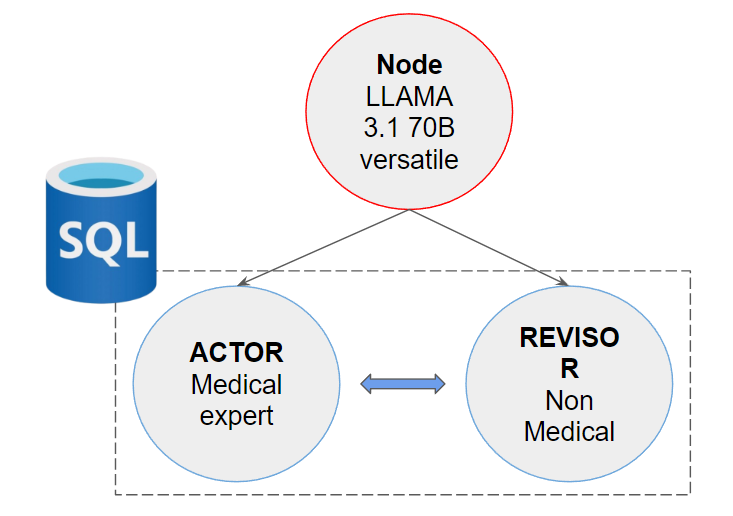

In [ ]:
# Test 3: Combining Memory and Reflection
memory_manager.clear_all_history()  # Clear memory to start fresh
session_id = "session_epilepsy"

init_prompt = "What is epilepsy?"
for i in range(3):
    print(f"Iteration {i + 1}: {init_prompt}")
    # Actor attempts to answer without medical knowledge
    actor_response = actor.act(init_prompt).get("response_content")
    memory_manager.display_session_history()  # Store in memory

    # Revisor critiques the response
    actor_response = revisor.revise(actor_response).get("response_content")
    print(f"Revised Response with Memory and Reflection: {actor_response}")

Iteration 1: What is epilepsy?
+----+---------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| ID |  Session ID   |                                                                                                                                                                                                                                                             Role                                                                                                                                                           

KeyboardInterrupt: 